In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from HanTa import HanoverTagger as ht
%matplotlib inline

nltk.download('wordnet')
nltk.download("stopwords")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic Modelling

For topic modelling the same data set as for the sentiment analysis is used, which means that tweets not directly containing the hashtag, as well as retweets are removed. 

In [2]:
df = pd.read_csv ('data/tweets/IchBinHannaUser.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag','user.group']]

In [3]:
df.columns

Index(['author.description', 'author.id', 'author.name',
       'author.public_metrics.followers_count',
       'author.public_metrics.following_count', 'author.username', 'author_id',
       'created_at', 'id', 'lang', 'public_metrics.retweet_count', 'text',
       'hashtags', 'reference_type', 'wanted_tag', 'user.group'],
      dtype='object')

In [4]:
#get the correct data
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df['processed'] = df['text'].astype(str)
df['processed'] = df['processed'].replace(r'\\n',  ' ', regex=True)

In [5]:
#clean the data (remove URLs, emojis and line breaks)
pat1 = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
pat2 = r'www.[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
split_pattern = re.compile(r'\b('  + r')\b')
def tweet_cleaner(demo):
    soup = BeautifulSoup(demo, 'lxml') # HTML
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    return stripped
df['processed'] = [tweet_cleaner(t) for t in df['processed']]
def rem_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI]
    cleaned = ' '.join([str for str in text.split() if not any(i in str for i in emojis)])
    return cleaned
df['processed'] = df['processed'].apply(lambda x: rem_emojis(x))
df['processed'] = df['processed'].astype(str)

In [6]:
#preprocessing (tokenization, stop word removal, lemmatizing)
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
add_stop_all = ["ichbinhanna","#ichbinhanna", "hanna", "mehr", "innen", "#wisszeitvg", "#ichbinhannah", "@amreibahr", "amreibahr", "@bmf_bund","bmf_bund", "@drkeichhorn", "drkeichhorn", "@sebastiankubon", "sebastiankubon", "@bmbf_bund", "mehr", "innen", "schon", "gehen", "jahr","wissenschaft", "wissenschaftler", "kommen","academia", "academic", "year", "machen", "sagen", "sein","geben", "also", "werden", "german", "germany","gut", "haben", "geht", "gibt", "viele", "seit", "wäre", "sehen", "ganz","bekommen"]
german_stop.update(set(add_stop_all))
english_stop.update(set(add_stop_all))
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['processed'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
#remove all words consisting of 3 characters or less to shorten the dictionary of unique words
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in english_stop]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in german_stop]).split(),axis=1)
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if len(word) > 3])
lemmatizer = WordNetLemmatizer()
hannover = ht.HanoverTagger('morphmodel_ger.pgz')
df['lemmatized'] = df[['tokenized','lang']].apply(lambda x: [lemmatizer.lemmatize(word).lower() for word in x['tokenized']] if x['lang'] == 'en' else [hannover.analyze(word)[0].lower() for word in x['tokenized']] ,axis=1)

In [7]:
def perform_LDA(tokens, topics=5, passes =5, alpha = 'symmetric', decay = 0.5):
    #create the dictionary of lemmatized tokens
    dic = Dictionary(tokens)
    #print(len(dic))
    #remove low and high frequent terms
    dic.filter_extremes(no_below=2, no_above=.99)
    #print(len(dic))
    #create the bag of words 
    corpus = [dic.doc2bow(d) for d in tokens]
    #build LDA model 
    LDA = LdaMulticore(corpus= corpus, num_topics=topics, id2word= dic, workers=12, passes=passes, alpha = alpha, decay = decay)
    words = [re.findall(r'"([^"]*)"',t[1]) for t in LDA.print_topics()]
    #create topics
    topics = [' '.join(t[0:10]) for t in words]

    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")
    # Compute Perplexity
    perplexity = LDA.log_perplexity(corpus)
    #print('\nPerplexity: ', perplexity) 
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=LDA, texts=tokens, 
                                   dictionary=dic, coherence='c_v')
    coherence_lda_model = coherence_model.get_coherence()
    #print('\nCoherence Score: ', coherence_lda_model)
    return LDA

In [8]:
#perform topic modelling by applying LDA on the whole data set, and on the german/english only sets (guided by: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
#full data set
full_model = perform_LDA(df['tokenized'])

------ Topic 0 ------
jahre jahren #hannaimbundestag promotion forschung @anjakarliczek gerade zeit system stelle

------ Topic 1 ------
system thread forschung gerade stellen lehre diskussion vertrag #ichbinreyhan jahren

------ Topic 2 ------
@anjakarliczek warum stellen @gew_bund frage einfach immer #hannaimbundestag dafür system

------ Topic 3 ------
immer danke @anjakarliczek heute menschen macht #ichbinreyhan jahre hochschulen unis

------ Topic 4 ------
@anjakarliczek system #ichbinreyhan arbeit #hannaimbundestag immer eigentlich unis problem bitte



In [9]:
#only german tweets
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]
ger_model = perform_LDA(df_ger['tokenized'])

------ Topic 0 ------
@anjakarliczek einfach #hannaimbundestag unis forschung wirklich macht heute stellen stelle

------ Topic 1 ------
jahre gerade stellen stelle jahren system deutschland unis promotion forschung

------ Topic 2 ------
#hannaimbundestag zeit @anjakarliczek jahren arbeitsbedingungen promotion vielen letzten warum hashtag

------ Topic 3 ------
forschung immer menschen gute hochschulen arbeit #dauerstellen @anjakarliczek #hannaimbundestag @gew_bund

------ Topic 4 ------
#ichbinreyhan immer promotion system heute arbeit danke macht thema müssen



In [10]:
#only english tweets
en_model = perform_LDA(df_en['tokenized'])

------ Topic 0 ------
like work conditions years precarious want @mahaelhissy story contracts share

------ Topic 1 ------
many research working good conditions system permanent researchers @anjakarliczek career

------ Topic 2 ------
years system time academics researchers contracts research people teaching future

------ Topic 3 ------
research system #ichbinreyhan working career conditions people precarity know scientists

------ Topic 4 ------
thread system work contract years many permanent without contracts need



In [11]:
#get topics by month
df_june = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-06-30 23:59:59')]
df_july = df.loc[(df['new_date'] > '2021-07-01 00:00:00') & (df['new_date'] <= '2021-07-31 23:59:59')]
df_august = df.loc[(df['new_date'] > '2021-08-01 00:00:00') & (df['new_date'] <= '2021-08-31 23:59:59')]
df_september = df.loc[(df['new_date'] > '2021-09-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [12]:
#tweets from june
june_model = perform_LDA(df_june['tokenized'])

------ Topic 0 ------
@anjakarliczek #hannaimbundestag jahren immer gerade #95vswisszeitvg system wohl lehre gemacht

------ Topic 1 ------
warum jahre zeit video promotion forschung stellen jahren @anjakarliczek menschen

------ Topic 2 ------
stelle system forschung thread innovation einfach lehre problem deutschland jahre

------ Topic 3 ------
jahre system #hannaimbundestag @anjakarliczek stellen unis warum promotion gerade problem

------ Topic 4 ------
#hannaimbundestag hashtag hochschulen forschung arbeitsbedingungen eigentlich letzten jahren immer heute



In [13]:
#tweets from july
july_model = perform_LDA(df_july['tokenized'])

------ Topic 0 ------
@anjakarliczek immer einfach thread müssen wurde #hannabeidergew arbeit deutschland eigentlich

------ Topic 1 ------
jahren @gew_bund beitrag stellen vielen dauerstellen danke macht niemand lehre

------ Topic 2 ------
system zeit #ichbinreyhan work problem @tagesthemen immer @gew_bund stelle research

------ Topic 3 ------
#ichbinreyhan @anjakarliczek arbeitsbedingungen forschung gerade @tagesthemen heute gute dank lehre

------ Topic 4 ------
system @anjakarliczek #ichbinreyhan warum jahre forschung unis macht nachwuchs eigentlich



In [14]:
#tweets from august
august_model = perform_LDA(df_august['tokenized'])

------ Topic 0 ------
zeit #ichbinreyhan #waspostdocswollen immer forschung beitrag stelle lehre macht heute

------ Topic 1 ------
#ichbinreyhan @anjakarliczek stellen sprechen aktuellen @mahaelhissy folge system @karolinedoering @gew_bund

------ Topic 2 ------
#ichbinreyhan @anjakarliczek gute forschung #wissenschaft einfach zeit problem gerade teil

------ Topic 3 ------
#ichbinreyhan #dauerstellen vielleicht heute immer @gew_bund system gerade genau @akellergew

------ Topic 4 ------
system #ichbinreyhan statt dafür immer @anjakarliczek arbeit jahren nachwuchs warum



In [15]:
#tweets from september
september_model = perform_LDA(df_september['tokenized'])

------ Topic 0 ------
#ichbinreyhan immer stelle stellen davon @jenniferhenkehb system postdocs erst heute

------ Topic 1 ------
#ichbinreyhan neue danke #btw21 #entfristethanna #berlhg @swh_hb berliner @andreasbovensc1 wählen

------ Topic 2 ------
monate forschung jahren arbeit gerade lehre #ichbinreyhan stelle hochschulen finde

------ Topic 3 ------
stellen #hannainzahlen vertrag hochschulen heute ende arbeitsverträge jahren monate unis

------ Topic 4 ------
@gew_bund #dauerstellen gute heute #ichbinreyhan unis gerade müssen lehre arbeitsbedingungen



In [16]:
def visualize_topics(tokens):
    #Visualization of topic distance 
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    #create the bag of words 
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    #build LDA model a 
    vis_LDA = LdaMulticore(corpus= vis_corpus, num_topics=5, id2word= vis_dic, workers=12, passes=5, random_state = 1)
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(vis_LDA, vis_corpus, vis_dic)
def visualize_model(model, tokens):
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(model, vis_corpus, vis_dic)

In [17]:
visualize_topics(df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.057497 -0.031243       1        1  23.691612
3      0.041353  0.006315       2        1  21.633222
1     -0.007103 -0.061808       3        1  18.584007
0      0.066461  0.011412       4        1  18.543499
2     -0.043214  0.075324       5        1  17.547661, topic_info=                Term        Freq       Total Category  logprob  loglift
1650          jahren  602.000000  602.000000  Default  30.0000  30.0000
1664         letzten  273.000000  273.000000  Default  29.0000  29.0000
197   @anjakarliczek  902.000000  902.000000  Default  28.0000  28.0000
65            thread  398.000000  398.000000  Default  27.0000  27.0000
1599           jahre  682.000000  682.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
405            heute   85.265278  519.069537   Topic5  -6.1212  -0.0660
867            immer   90.660039  690.755322   Topic5  -6.0599  -0.2904
835           gerade   75.055211  573.588230   Topic5  -6.2488  -0.2934
1690     deutschland   70.669527  388.377378   Topic5  -6.3090   0.0363
1325            unis   68.643194  456.308964   Topic5  -6.3381  -0.1540

[495 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1571      1  0.260494  #95vswisszeitvg
1571      2  0.135457  #95vswisszeitvg
1571      3  0.090305  #95vswisszeitvg
1571      4  0.142403  #95vswisszeitvg
1571      5  0.371638  #95vswisszeitvg
...     ...       ...              ...
4047      5  0.080538            ️ende
4050      1  0.087544      ️stipendium
4050      2  0.787894      ️stipendium
4050      3  0.087544      ️stipendium
4050      5  0.087544      ️stipendium

[1311 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [18]:
def create_dic_corpus(tokens):
    dic = Dictionary(tokens)
    dic.filter_extremes(no_below=2, no_above=.99)
    corpus = [dic.doc2bow(d) for d in tokens]
    return dic, corpus
#get optimal number of topics for each (sub)set
def compute_coherence_values_topics(tokens, limit=10, start=2, step=1):
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, random_state = 1)
        model_list_topic.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    print(model_list_topic, coherence_values_topic)
    
def compute_coherence_values_passes(tokens,num_topics):
    
    passes = [5,10,15,20]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_passes = []
    model_list_passes = []
    for num_pass in passes:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = num_pass, random_state = 1)
        model_list_passes.append(num_pass)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_passes.append(coherencemodel.get_coherence())

    print(model_list_passes, coherence_values_passes)
    
def compute_coherence_values_alpha(tokens,num_topics, passes):
    
    alpha = ['symmetric','asymmetric']
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_alpha = []
    model_list_alpha = []
    for a in alpha:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = a, random_state = 1)
        model_list_alpha.append(a)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_alpha.append(coherencemodel.get_coherence())

    print(model_list_alpha, coherence_values_alpha)
    
def compute_coherence_values_decay(tokens,num_topics, passes, alpha):
    
    decay = [0.5,0.7,0.9]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_decay = []
    model_list_decay = []
    for d in decay:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = alpha, random_state = 1, decay =d)
        model_list_decay.append(d)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_decay.append(coherencemodel.get_coherence())

    print(model_list_decay, coherence_values_decay)

In [19]:
#full data
compute_coherence_values_topics(df['tokenized'])
#english data
compute_coherence_values_topics(df_en['tokenized'])
#german data
compute_coherence_values_topics(df_ger['tokenized'])
#june data
compute_coherence_values_topics(df_june['tokenized'])
#july data
compute_coherence_values_topics(df_july['tokenized'])
#august data
compute_coherence_values_topics(df_august['tokenized'])
#september data
compute_coherence_values_topics(df_september['tokenized'])

[2, 3, 4, 5, 6, 7, 8, 9] [0.20724123479308415, 0.14448147382907475, 0.1257679633885763, 0.12417968751444412, 0.12434549641029474, 0.12053637810282873, 0.12053284118709445, 0.13275832083547934]
[2, 3, 4, 5, 6, 7, 8, 9] [0.15872127318363816, 0.19042360868727096, 0.19232521362221944, 0.1782942342540139, 0.19811954951734215, 0.22057608859820052, 0.23112207314892452, 0.24310587320493685]
[2, 3, 4, 5, 6, 7, 8, 9] [0.14905430267919023, 0.1194570446548613, 0.10508421337504459, 0.11628804625250047, 0.12496391611286077, 0.11995792823019658, 0.1222687308026342, 0.12967560010868884]
[2, 3, 4, 5, 6, 7, 8, 9] [0.19627746650085187, 0.15077720270219788, 0.17878527266043734, 0.14748414410889438, 0.2023685490041651, 0.20389371697150396, 0.18867094224611344, 0.18851741272588993]
[2, 3, 4, 5, 6, 7, 8, 9] [0.2718678044645053, 0.3227806572504709, 0.33341964020152204, 0.31513115914356327, 0.3137663993811249, 0.3172137196788887, 0.34619266611987265, 0.3582727662739486]
[2, 3, 4, 5, 6, 7, 8, 9] [0.441388559102

In [20]:
#full data
compute_coherence_values_passes(df['tokenized'], 6)
#english data
compute_coherence_values_passes(df_en['tokenized'],7)
#german data
compute_coherence_values_passes(df_ger['tokenized'],8)
#june data
compute_coherence_values_passes(df_june['tokenized'],7)
#july data
compute_coherence_values_passes(df_july['tokenized'],7)
#august data
compute_coherence_values_passes(df_august['tokenized'],7)
#september data
compute_coherence_values_passes(df_september['tokenized'],6)

[5, 10, 15, 20] [0.19744003721951384, 0.1989849373548963, 0.2544503969668967, 0.26634020674493475]
[5, 10, 15, 20] [0.23652599927539747, 0.2372808662198025, 0.2391021912287965, 0.2355887868609557]
[5, 10, 15, 20] [0.14499457901403184, 0.18157022353088265, 0.20408439917939752, 0.2167578576343554]
[5, 10, 15, 20] [0.19171678630000014, 0.22519885477649798, 0.22644720596750254, 0.2509786865249606]
[5, 10, 15, 20] [0.32488283320194006, 0.36579828525289276, 0.3565916222980972, 0.34564263174998133]
[5, 10, 15, 20] [0.38716670470480663, 0.4019267073565121, 0.39785400748485866, 0.4104051650525607]
[5, 10, 15, 20] [0.3815216388916145, 0.38164615172150335, 0.3779828879515213, 0.3742828207688374]


In [21]:
#full data
compute_coherence_values_alpha(df['tokenized'], 6,20)
#english data
compute_coherence_values_alpha(df_en['tokenized'],7,20)
#german data
compute_coherence_values_alpha(df_ger['tokenized'],8,20)
#june data
compute_coherence_values_alpha(df_june['tokenized'],7,20)
#july data
compute_coherence_values_alpha(df_july['tokenized'],7,15)
#august data
compute_coherence_values_alpha(df_august['tokenized'],7,20)
#september data
compute_coherence_values_alpha(df_september['tokenized'],6,20)

['symmetric', 'asymmetric'] [0.2643930755556711, 0.2939875265405616]
['symmetric', 'asymmetric'] [0.2355887868609557, 0.28983941056029866]
['symmetric', 'asymmetric'] [0.2144643447401345, 0.23772557557181523]
['symmetric', 'asymmetric'] [0.253076687218579, 0.3688305100252523]
['symmetric', 'asymmetric'] [0.3565916222980972, 0.3702861438823315]
['symmetric', 'asymmetric'] [0.4104051650525607, 0.43244752279392706]
['symmetric', 'asymmetric'] [0.3742828207688374, 0.5454697500370588]


In [22]:
#full data
compute_coherence_values_decay(df['tokenized'], 6,20,'asymmetric')
#english data
compute_coherence_values_decay(df_en['tokenized'],7,20,'symmetric')
#german data
compute_coherence_values_decay(df_ger['tokenized'],8,20,'symmetric')
#june data
compute_coherence_values_decay(df_june['tokenized'],7,20,'asymmetric')
#july data
compute_coherence_values_decay(df_july['tokenized'],7,20,'asymmetric')
#august data
compute_coherence_values_decay(df_august['tokenized'],7,20,'asymmetric')
#september data
compute_coherence_values_decay(df_september['tokenized'],6,5,'symmetric')

[0.5, 0.7, 0.9] [0.2939875265405616, 0.2841502272673161, 0.22108765776595596]
[0.5, 0.7, 0.9] [0.2355887868609557, 0.23721491714829096, 0.24150878301389936]
[0.5, 0.7, 0.9] [0.21675785763435537, 0.1823240346618259, 0.15115262497275778]
[0.5, 0.7, 0.9] [0.35539561211112514, 0.31465590405792054, 0.24353233632524923]
[0.5, 0.7, 0.9] [0.34438475471875585, 0.3792955333717977, 0.3742203087340466]
[0.5, 0.7, 0.9] [0.43244752279392706, 0.42360111396249894, 0.420523596028651]
[0.5, 0.7, 0.9] [0.3815216388916145, 0.3842196613348565, 0.3825162828336612]


In [23]:
#get the optimal models
print('Topics for the whole model')
optimal_full = perform_LDA(df['tokenized'],6,20,'asymmetric',0.5)
print('Topics for the English model')
optimal_en = perform_LDA(df_en['tokenized'],7,20,'symmetric',0.5)
print('Topics for the German model')
optimal_ger = perform_LDA(df_ger['tokenized'],8,20,'symmetric',0.5)
print('Topics for the June model')
optimal_june = perform_LDA(df_june['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the July model')
optimal_july = perform_LDA(df_july['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the August model')
optimal_august = perform_LDA(df_august['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the September model')
optimal_september = perform_LDA(df_september['tokenized'],6,5,'asymmetric',0.9)

Topics for the whole model
------ Topic 0 ------
@anjakarliczek #hannaimbundestag #ichbinreyhan immer gerade danke system heute warum unis

------ Topic 1 ------
forschung lehre arbeitsbedingungen @gew_bund #dauerstellen #wissenschaft stellen letzten zeit hashtag

------ Topic 2 ------
system research work years contracts thread many working conditions researchers

------ Topic 3 ------
jahre stelle jahren immer befristet promotion forschung eigentlich zeit arbeiten

------ Topic 4 ------
@gew_bund müssen zeit #dauerstellen system erst @anjakarliczek tenure niemand @nga_wiss

------ Topic 5 ------
promotion @anjakarliczek gemacht system studiert dafür forschung eher natürlich abschluss

Topics for the English model
------ Topic 0 ------
researchers system conditions people working academics precarious career many years

------ Topic 1 ------
thread english #acertaindegreeofflexibility career still conditions working follow professors time

------ Topic 2 ------
thread system research c

In [24]:
visualize_model(optimal_full, df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.090409  0.005255       1        1  45.774125
1     -0.084481 -0.029770       2        1  18.807957
2      0.298319 -0.036088       3        1  13.420603
3     -0.100601 -0.117473       4        1  12.054224
4     -0.025562  0.126470       5        1   5.543174
5      0.002733  0.051605       6        1   4.399916, topic_info=                   Term        Freq       Total Category  logprob  loglift
1599              jahre  689.000000  689.000000  Default  30.0000  30.0000
1955             stelle  508.000000  508.000000  Default  29.0000  29.0000
1037          forschung  713.000000  713.000000  Default  28.0000  28.0000
1650             jahren  610.000000  610.000000  Default  27.0000  27.0000
101              system  775.000000  775.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
885              besser   15.889765  214.861564   Topic6  -6.4180   0.5193
897                zeit   18.198451  502.725513   Topic6  -6.2823  -0.1951
3026            einfach   16.967943  431.838898   Topic6  -6.3523  -0.1131
1064              warum   16.443044  491.735766   Topic6  -6.3838  -0.2745
1187  wissenschaftliche   14.668549  172.440625   Topic6  -6.4980   0.6592

[481 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
13785      4  0.867732        #allesistdrin
10086      2  0.960338  #arbeitsbedingungen
5266       1  0.027184            #baerbock
5266       3  0.081552            #baerbock
5266       4  0.897070            #baerbock
...      ...       ...                  ...
2556       1  0.369168           österreich
2556       2  0.287131           österreich
2556       4  0.041019           österreich
2556       5  0.307640           österreich
8017       6  0.883240            überhöhte

[1280 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [25]:
visualize_model(optimal_en, df_en['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.061737 -0.054046       1        1  17.786082
2      0.029259 -0.016238       2        1  16.824401
6      0.067043 -0.009554       3        1  16.408505
3      0.033531  0.025793       4        1  15.050874
5     -0.128663 -0.117618       5        1  12.411038
4      0.034432  0.039188       6        1  11.756048
1     -0.097339  0.132475       7        1   9.763053, topic_info=            Term        Freq       Total Category  logprob  loglift
51        thread  140.000000  140.000000  Default  30.0000  30.0000
2208   passports   38.000000   38.000000  Default  29.0000  29.0000
259        years  160.000000  160.000000  Default  28.0000  28.0000
1053    contract   81.000000   81.000000  Default  27.0000  27.0000
424     scholars  106.000000  106.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
149         read    9.467249   71.781169   Topic7  -5.7036   0.3008
396      hashtag    8.748613   51.520666   Topic7  -5.7826   0.5535
87        system   10.040612  231.196541   Topic7  -5.6448  -0.8101
892   employment    8.420066   58.859987   Topic7  -5.8208   0.3820
166       people    8.510799  122.938247   Topic7  -5.8101  -0.3438

[560 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1102      2  0.387190  #95vswisszeitvg
1102      3  0.059568  #95vswisszeitvg
1102      5  0.208487  #95vswisszeitvg
1102      7  0.327622  #95vswisszeitvg
1474      1  0.121326        #academia
...     ...       ...              ...
796       2  0.175836            young
796       3  0.117224            young
796       4  0.078149            young
796       5  0.097686            young
796       6  0.097686            young

[1305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 7, 4, 6, 5, 2])

In [26]:
visualize_model(optimal_ger, df_ger['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.027201 -0.007390       1        1  15.171071
3      0.046161  0.018372       2        1  14.083067
4     -0.003753  0.015343       3        1  12.796801
1      0.063612  0.042973       4        1  12.763871
0      0.044362  0.051447       5        1  12.706814
7     -0.155636  0.030301       6        1  11.103205
6      0.023564  0.003504       7        1  10.869624
2      0.008891 -0.154550       8        1  10.505549, topic_info=                Term        Freq       Total Category  logprob  loglift
2605       @gew_bund  408.000000  408.000000  Default  30.0000  30.0000
2573         hashtag  272.000000  272.000000  Default  29.0000  29.0000
3555   #dauerstellen  217.000000  217.000000  Default  28.0000  28.0000
1131  @anjakarliczek  839.000000  839.000000  Default  27.0000  27.0000
665          stellen  580.000000  580.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
82           sollten   37.788896  154.914908   Topic8  -6.2728   0.8424
288             klar   40.033905  217.573495   Topic8  -6.2151   0.5605
247        forschung   44.708691  710.142402   Topic8  -6.1047  -0.5120
181            lehre   42.087907  527.118533   Topic8  -6.1651  -0.2744
511            wurde   40.345116  321.551603   Topic8  -6.2074   0.1776

[692 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
733       1  0.108753           #95vswisszeitvg
733       2  0.493271           #95vswisszeitvg
733       3  0.023304           #95vswisszeitvg
733       4  0.019420           #95vswisszeitvg
733       5  0.023304           #95vswisszeitvg
...     ...       ...                       ...
2743      4  0.895752        ️arbeitsortwechsel
2744      4  0.930515          ️arbeitsverträge
2745      4  0.908597                     ️ende
2746      4  0.859352  ️erwerbsarbeitslosigkeit
2748      4  0.894910               ️stipendium

[2005 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 2, 1, 8, 7, 3])

In [27]:
visualize_model(optimal_june, df_june['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.076517 -0.003865       1        1  31.470733
1      0.021991  0.005518       2        1  19.140139
3      0.081428  0.079735       3        1  16.426397
2      0.006377 -0.158571       4        1  11.236510
5      0.073207 -0.001920       5        1   8.246198
6      0.050250  0.032081       6        1   7.148572
4     -0.156736  0.047022       7        1   6.331450, topic_info=                    Term        Freq       Total Category  logprob  loglift
87        @anjakarliczek  607.000000  607.000000  Default  30.0000  30.0000
375                jahre  505.000000  505.000000  Default  29.0000  29.0000
854               stelle  328.000000  328.000000  Default  28.0000  28.0000
701              stellen  331.000000  331.000000  Default  27.0000  27.0000
502            promotion  333.000000  333.000000  Default  26.0000  26.0000
...                  ...         ...         ...      ...      ...      ...
926                leute   15.711368  195.350713   Topic7  -6.2199   0.2392
870                heute   16.302193  285.585142   Topic7  -6.1830  -0.1036
1038  arbeitsbedingungen   15.255532  238.352268   Topic7  -6.2494   0.0108
768                years   14.662601  100.377401   Topic7  -6.2890   0.8360
647          hochschulen   14.924363  225.856370   Topic7  -6.2713   0.0427

[582 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
331       1  0.579512  #95vswisszeitvg
331       2  0.082787  #95vswisszeitvg
331       4  0.046568  #95vswisszeitvg
331       5  0.072439  #95vswisszeitvg
331       6  0.129355  #95vswisszeitvg
...     ...       ...              ...
434       3  0.178748         übrigens
434       4  0.069945         übrigens
434       5  0.038858         übrigens
434       6  0.194291         übrigens
434       7  0.023315         übrigens

[1553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 6, 7, 5])

In [28]:
visualize_model(optimal_july, df_july['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.112064  0.006536       1        1  44.861313
1      0.209243 -0.022987       2        1  17.753961
2     -0.052969 -0.059989       3        1  10.672670
3     -0.060383  0.158298       4        1   8.582115
4     -0.067438 -0.112615       5        1   6.953289
5      0.106380  0.038939       6        1   6.221342
6     -0.022769 -0.008182       7        1   4.955309, topic_info=                              Term        Freq       Total Category  logprob  \
674                          warum   82.000000   82.000000  Default  30.0000   
2050                #frististfrust   65.000000   65.000000  Default  29.0000   
865   #acertaindegreeofflexibility   39.000000   39.000000  Default  28.0000   
515                          immer  146.000000  146.000000  Default  27.0000   
1295                        stelle   75.000000   75.000000  Default  26.0000   
...                            ...         ...         ...      ...      ...   
1219                        leider    4.636052   62.056643   Topic7  -6.1578   
1340                         dafür    4.498976   69.624170   Topic7  -6.1878   
1368                         leute    4.477931   60.315472   Topic7  -6.1925   
95                          system    4.528542  137.931336   Topic7  -6.1813   
1070                         heute    4.490806  105.348234   Topic7  -6.1896   

      loglift  
674   30.0000  
2050  29.0000  
865   28.0000  
515   27.0000  
1295  26.0000  
...       ...  
1219   0.4105  
1340   0.2654  
1368   0.4043  
95    -0.4116  
1070  -0.1505  

[515 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2080      1  0.348681  #95vswisszeitvg
2080      2  0.024906  #95vswisszeitvg
2080      3  0.149435  #95vswisszeitvg
2080      4  0.049812  #95vswisszeitvg
2080      5  0.398493  #95vswisszeitvg
...     ...       ...              ...
1516      7  0.078290             zwei
4525      7  0.669333            zähle
4059      3  0.693212   öffentlichkeit
4059      4  0.099030   öffentlichkeit
4059      5  0.099030   öffentlichkeit

[1112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [29]:
visualize_model(optimal_august, df_august['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.052638 -0.031573       1        1  37.184624
1      0.112947  0.009444       2        1  22.360069
2     -0.085705  0.112715       3        1  14.058272
3      0.024011 -0.111370       4        1  11.047670
6     -0.051946 -0.061087       5        1   5.376756
5      0.097748  0.070826       6        1   5.342309
4     -0.044417  0.011045       7        1   4.630301, topic_info=                Term        Freq       Total Category  logprob  loglift
15     #ichbinreyhan  135.000000  135.000000  Default  30.0000  30.0000
84             heute   47.000000   47.000000  Default  29.0000  29.0000
346           jahren   34.000000   34.000000  Default  28.0000  28.0000
696   @anjakarliczek   72.000000   72.000000  Default  27.0000  27.0000
373            angst   22.000000   22.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1002       @gew_bund    3.047787   52.318933   Topic7  -5.6669   0.2296
939        situation    2.468312   20.905676   Topic7  -5.8777   0.9361
302            immer    2.831013   73.298538   Topic7  -5.7406  -0.1814
25            system    2.838819   77.188896   Topic7  -5.7379  -0.2303
473        forschung    2.498504   64.698720   Topic7  -5.8656  -0.1815

[481 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1457      1  0.352132  #95vswisszeitvg
1457      2  0.201218  #95vswisszeitvg
1457      3  0.352132  #95vswisszeitvg
1457      6  0.050305  #95vswisszeitvg
1008      1  0.893176    #95wisspausen
...     ...       ...              ...
308       5  0.145679           ändern
308       6  0.145679           ändern
468       2  0.924757          überall
2011      1  0.942794     überraschend
704       6  0.457117      überzeugend

[1047 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 7, 6, 5])

In [30]:
visualize_model(optimal_september, df_september['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.003344 -0.022800       1        1  44.266068
1      0.024109 -0.052109       2        1  21.314253
2      0.024897 -0.057128       3        1  10.943108
3     -0.158947  0.019627       4        1  10.311916
5      0.052669  0.148938       5        1   6.903360
4      0.053928 -0.036530       6        1   6.261295, topic_info=                Term       Freq       Total Category  logprob  loglift
125           monate  39.000000   39.000000  Default  30.0000  30.0000
115   #hannainzahlen  45.000000   45.000000  Default  29.0000  29.0000
13            system  46.000000   46.000000  Default  28.0000  28.0000
68            gerade  50.000000   50.000000  Default  27.0000  27.0000
340           #btw21  35.000000   35.000000  Default  26.0000  26.0000
...              ...        ...         ...      ...      ...      ...
369      deutschland   2.821073   25.737682   Topic6  -5.9273   0.5599
394          stellen   3.113103   59.804956   Topic6  -5.8288  -0.1847
184           themen   2.531983   12.429987   Topic6  -6.0354   1.1797
51     #ichbinreyhan   2.916540  145.632910   Topic6  -5.8940  -1.1399
1234          gesetz   2.537245   22.471043   Topic6  -6.0333   0.5896

[426 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2365      1  0.823612     #academia
3246      4  0.105630          #afd
3246      5  0.845043          #afd
3271      5  0.893880     #baerbock
448       1  0.426315       #berlhg
...     ...       ...           ...
446       1  0.134069       ️kinder
446       2  0.134069       ️kinder
446       4  0.804416       ️kinder
2683      4  0.811558  ️ortswechsel
447       4  0.910918   ️stipendium

[843 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 6, 5])

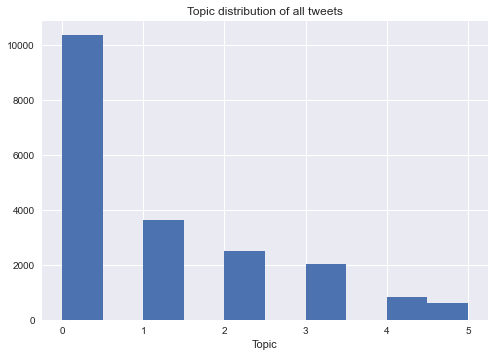

In [31]:
#explicitly get topic distribution (to get total number of tweets per topic)
def get_top_topic(distribution):
    top_topic = 0
    top_prob = 0 
    for topic in distribution:
        if topic[1] > top_prob:
            top_topic = topic[0]
            top_prob = topic[1] 
    return top_topic
#get topic probabilities for all tweets
plt.style.use('seaborn')
full_dic, full_corpus = create_dic_corpus(df['tokenized'])
df['topic distribution'] = df['tokenized'].apply(lambda x: optimal_full.get_document_topics(full_dic.doc2bow(x)))
df['topic'] = df['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df['topic'].hist()
plt.title('Topic distribution of all tweets')
plt.xlabel('Topic')
plt.savefig('topic_hist.pdf')
plt.show()

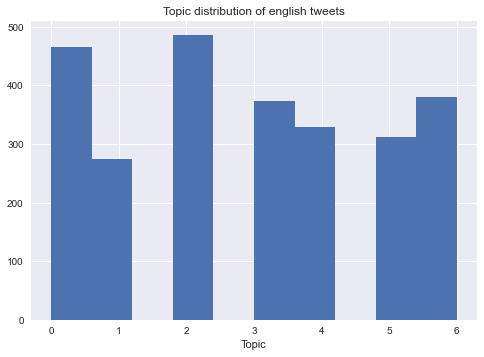

In [32]:
#get topic probabilities for all tweets
en_dic, en_corpus = create_dic_corpus(df_en['tokenized'])
df_en['topic distribution'] = df_en['tokenized'].apply(lambda x: optimal_en.get_document_topics(en_dic.doc2bow(x)))
df_en['topic'] = df_en['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_en['topic'].hist()
plt.title('Topic distribution of english tweets')
plt.xlabel('Topic')
plt.show()

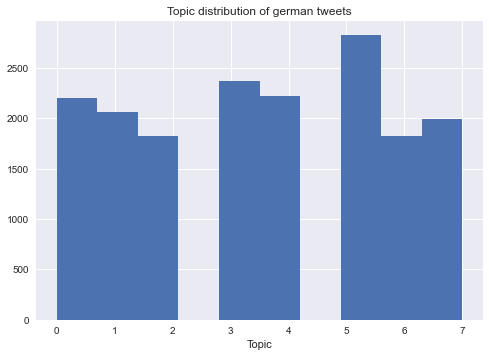

In [33]:
#get topic probabilities for all tweets
ger_dic, ger_corpus = create_dic_corpus(df_ger['tokenized'])
df_ger['topic distribution'] = df_ger['tokenized'].apply(lambda x: optimal_ger.get_document_topics(ger_dic.doc2bow(x)))
df_ger['topic'] = df_ger['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_ger['topic'].hist()
plt.title('Topic distribution of german tweets')
plt.xlabel('Topic')
plt.show()

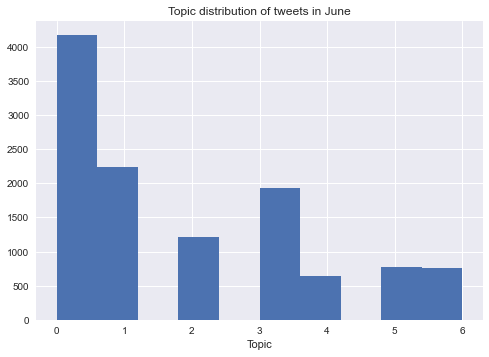

In [34]:
#get topic probabilities for all tweets
june_dic, june_corpus = create_dic_corpus(df_june['tokenized'])
df_june['topic distribution'] = df_june['tokenized'].apply(lambda x: optimal_june.get_document_topics(june_dic.doc2bow(x)))
df_june['topic'] = df_june['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_june['topic'].hist()
plt.title('Topic distribution of tweets in June')
plt.xlabel('Topic')
plt.show()

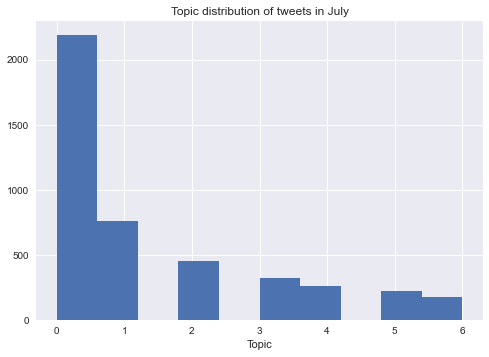

In [35]:
#get topic probabilities for all tweets
july_dic, july_corpus = create_dic_corpus(df_july['tokenized'])
df_july['topic distribution'] = df_july['tokenized'].apply(lambda x: optimal_july.get_document_topics(july_dic.doc2bow(x)))
df_july['topic'] = df_july['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_july['topic'].hist()
plt.title('Topic distribution of tweets in July')
plt.xlabel('Topic')
plt.show()

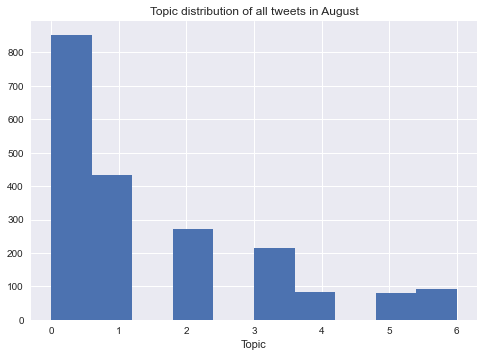

In [36]:
#get topic probabilities for all tweets
august_dic, august_corpus = create_dic_corpus(df_august['tokenized'])
df_august['topic distribution'] = df_august['tokenized'].apply(lambda x: optimal_august.get_document_topics(august_dic.doc2bow(x)))
df_august['topic'] = df_august['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_august['topic'].hist()
plt.title('Topic distribution of all tweets in August')
plt.xlabel('Topic')
plt.show()

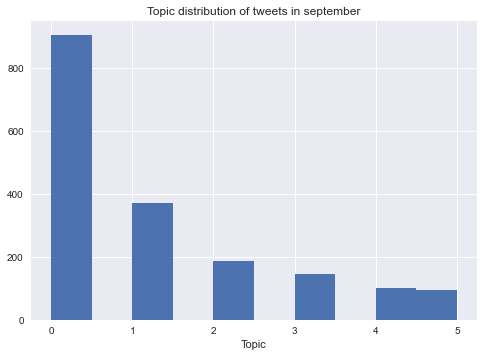

In [37]:
#get topic probabilities for all tweets
september_dic, september_corpus = create_dic_corpus(df_september['tokenized'])
df_september['topic distribution'] = df_september['tokenized'].apply(lambda x: optimal_september.get_document_topics(september_dic.doc2bow(x)))
df_september['topic'] = df_september['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_september['topic'].hist()
plt.title('Topic distribution of tweets in september')
plt.xlabel('Topic')
plt.show()

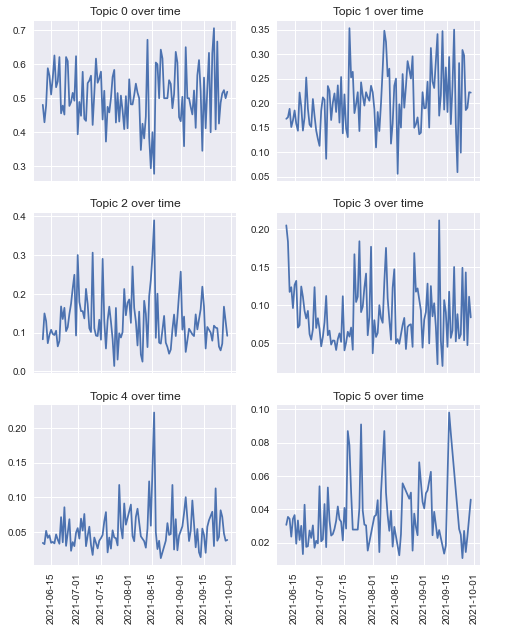

In [38]:
#show the development of tweet frequency of topics over time for the whole set; not particularly insightful for full data
df_topic0 = df.loc[df['topic'] == 0]
df_topic1 = df.loc[df['topic'] == 1]
df_topic2 = df.loc[df['topic'] == 2]
df_topic3 = df.loc[df['topic'] == 3]
df_topic4 = df.loc[df['topic'] == 4]
df_topic5 = df.loc[df['topic'] == 5]
#divide number of tweets of a topic at a day by the total number of topics on that day, to lessen the effect of days with a high tweet frequency
df_freqs = pd.DataFrame(pd.to_datetime(df['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = pd.DataFrame(pd.to_datetime(df_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = df_topic0.merge(df_freqs, on ='index')
df_topic0['count'] = df_topic0['new_date_x']/df_topic0['new_date_y'] 
df_topic1 = pd.DataFrame(pd.to_datetime(df_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic1 = df_topic1.merge(df_freqs, on ='index')
df_topic1['count'] = df_topic1['new_date_x']/df_topic1['new_date_y'] 
df_topic2 = pd.DataFrame(pd.to_datetime(df_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic2 = df_topic2.merge(df_freqs, on ='index')
df_topic2['count'] = df_topic2['new_date_x']/df_topic2['new_date_y'] 
df_topic3 = pd.DataFrame(pd.to_datetime(df_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic3 = df_topic3.merge(df_freqs, on ='index')
df_topic3['count'] = df_topic3['new_date_x']/df_topic3['new_date_y'] 
df_topic4 = pd.DataFrame(pd.to_datetime(df_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic4 = df_topic4.merge(df_freqs, on ='index')
df_topic4['count'] = df_topic4['new_date_x']/df_topic4['new_date_y'] 
df_topic5 = pd.DataFrame(pd.to_datetime(df_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic5 = df_topic5.merge(df_freqs, on ='index')
df_topic5['count'] = df_topic5['new_date_x']/df_topic5['new_date_y']
plt.subplot(3, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_topic0['index'], df_topic0['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_topic1['index'], df_topic1['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_topic2['index'], df_topic2['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_topic3['index'], df_topic3['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_topic4['index'], df_topic4['count'])
plt.xticks(rotation='vertical')
plt.subplot(3, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_topic5['index'], df_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

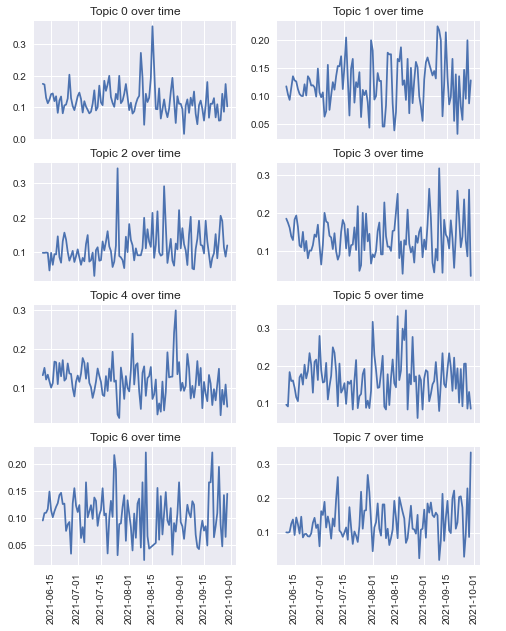

In [39]:
#show the development of tweet frequency of topics over time for the german tweets
df_ger_topic0 = df_ger.loc[df_ger['topic'] == 0]
df_ger_topic1 = df_ger.loc[df_ger['topic'] == 1]
df_ger_topic2 = df_ger.loc[df_ger['topic'] == 2]
df_ger_topic3 = df_ger.loc[df_ger['topic'] == 3]
df_ger_topic4 = df_ger.loc[df_ger['topic'] == 4]
df_ger_topic5 = df_ger.loc[df_ger['topic'] == 5]
df_ger_topic6 = df_ger.loc[df_ger['topic'] == 6]
df_ger_topic7 = df_ger.loc[df_ger['topic'] == 7]
df_ger_freqs = pd.DataFrame(pd.to_datetime(df_ger['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = pd.DataFrame(pd.to_datetime(df_ger_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = df_ger_topic0.merge(df_ger_freqs, on ='index')
df_ger_topic0['count'] = df_ger_topic0['new_date_x']/df_ger_topic0['new_date_y'] 
df_ger_topic1 = pd.DataFrame(pd.to_datetime(df_ger_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic1 = df_ger_topic1.merge(df_ger_freqs, on ='index')
df_ger_topic1['count'] = df_ger_topic1['new_date_x']/df_ger_topic1['new_date_y'] 
df_ger_topic2 = pd.DataFrame(pd.to_datetime(df_ger_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic2 = df_ger_topic2.merge(df_ger_freqs, on ='index')
df_ger_topic2['count'] = df_ger_topic2['new_date_x']/df_ger_topic2['new_date_y'] 
df_ger_topic3 = pd.DataFrame(pd.to_datetime(df_ger_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic3 = df_ger_topic3.merge(df_ger_freqs, on ='index')
df_ger_topic3['count'] = df_ger_topic3['new_date_x']/df_ger_topic3['new_date_y'] 
df_ger_topic4 = pd.DataFrame(pd.to_datetime(df_ger_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic4 = df_ger_topic4.merge(df_ger_freqs, on ='index')
df_ger_topic4['count'] = df_ger_topic4['new_date_x']/df_ger_topic4['new_date_y'] 
df_ger_topic5 = pd.DataFrame(pd.to_datetime(df_ger_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic5 = df_ger_topic5.merge(df_ger_freqs, on ='index')
df_ger_topic5['count'] = df_ger_topic5['new_date_x']/df_ger_topic5['new_date_y']
df_ger_topic6 = pd.DataFrame(pd.to_datetime(df_ger_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic6 = df_ger_topic6.merge(df_ger_freqs, on ='index')
df_ger_topic6['count'] = df_ger_topic6['new_date_x']/df_ger_topic6['new_date_y'] 
df_ger_topic7 = pd.DataFrame(pd.to_datetime(df_ger_topic7['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic7 = df_ger_topic7.merge(df_ger_freqs, on ='index')
df_ger_topic7['count'] = df_ger_topic7['new_date_x']/df_ger_topic7['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_ger_topic0['index'], df_ger_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_ger_topic1['index'], df_ger_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_ger_topic2['index'], df_ger_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_ger_topic3['index'], df_ger_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_ger_topic4['index'], df_ger_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_ger_topic5['index'], df_ger_topic5['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_ger_topic6['index'], df_ger_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 8)
plt.title('Topic 7 over time')
plt.plot(df_ger_topic7['index'], df_ger_topic7['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

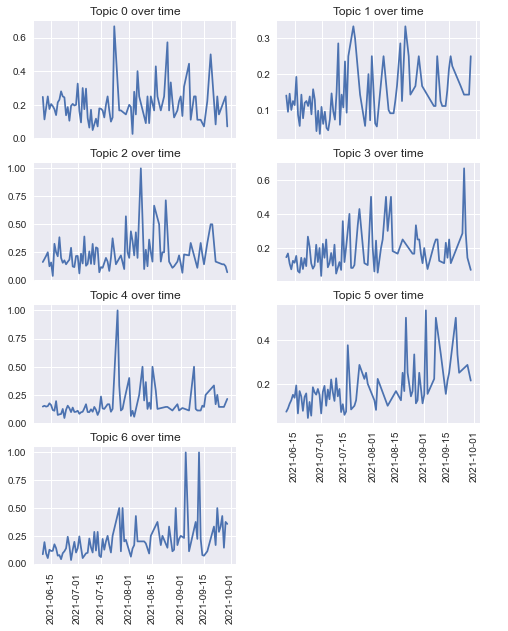

In [40]:
#show the development of tweet frequency of topics over time for the english tweets
df_en_topic0 = df_en.loc[df_en['topic'] == 0]
df_en_topic1 = df_en.loc[df_en['topic'] == 1]
df_en_topic2 = df_en.loc[df_en['topic'] == 2]
df_en_topic3 = df_en.loc[df_en['topic'] == 3]
df_en_topic4 = df_en.loc[df_en['topic'] == 4]
df_en_topic5 = df_en.loc[df_en['topic'] == 5]
df_en_topic6 = df_en.loc[df_en['topic'] == 6]
df_en_freqs = pd.DataFrame(pd.to_datetime(df_en['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = pd.DataFrame(pd.to_datetime(df_en_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = df_en_topic0.merge(df_en_freqs, on ='index')
df_en_topic0['count'] = df_en_topic0['new_date_x']/df_en_topic0['new_date_y'] 
df_en_topic1 = pd.DataFrame(pd.to_datetime(df_en_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic1 = df_en_topic1.merge(df_en_freqs, on ='index')
df_en_topic1['count'] = df_en_topic1['new_date_x']/df_en_topic1['new_date_y'] 
df_en_topic2 = pd.DataFrame(pd.to_datetime(df_en_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic2 = df_en_topic2.merge(df_en_freqs, on ='index')
df_en_topic2['count'] = df_en_topic2['new_date_x']/df_en_topic2['new_date_y'] 
df_en_topic3 = pd.DataFrame(pd.to_datetime(df_en_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic3 = df_en_topic3.merge(df_en_freqs, on ='index')
df_en_topic3['count'] = df_en_topic3['new_date_x']/df_en_topic3['new_date_y'] 
df_en_topic4 = pd.DataFrame(pd.to_datetime(df_en_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic4 = df_en_topic4.merge(df_en_freqs, on ='index')
df_en_topic4['count'] = df_en_topic4['new_date_x']/df_en_topic4['new_date_y'] 
df_en_topic5 = pd.DataFrame(pd.to_datetime(df_en_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic5 = df_en_topic5.merge(df_en_freqs, on ='index')
df_en_topic5['count'] = df_en_topic5['new_date_x']/df_en_topic5['new_date_y']
df_en_topic6 = pd.DataFrame(pd.to_datetime(df_en_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic6 = df_en_topic6.merge(df_en_freqs, on ='index')
df_en_topic6['count'] = df_en_topic6['new_date_x']/df_en_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_en_topic0['index'], df_en_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_en_topic1['index'], df_en_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_en_topic2['index'], df_en_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_en_topic3['index'], df_en_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_en_topic4['index'], df_en_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_en_topic5['index'], df_en_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_en_topic6['index'], df_en_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

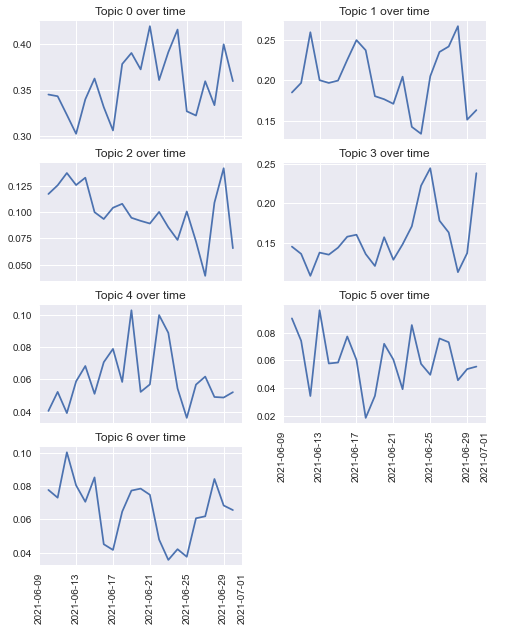

In [41]:
#show the development of tweet frequency of topics over time for the tweets in june
df_june_topic0 = df_june.loc[df_june['topic'] == 0]
df_june_topic1 = df_june.loc[df_june['topic'] == 1]
df_june_topic2 = df_june.loc[df_june['topic'] == 2]
df_june_topic3 = df_june.loc[df_june['topic'] == 3]
df_june_topic4 = df_june.loc[df_june['topic'] == 4]
df_june_topic5 = df_june.loc[df_june['topic'] == 5]
df_june_topic6 = df_june.loc[df_june['topic'] == 6]
df_june_freqs = pd.DataFrame(pd.to_datetime(df_june['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = pd.DataFrame(pd.to_datetime(df_june_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = df_june_topic0.merge(df_june_freqs, on ='index')
df_june_topic0['count'] = df_june_topic0['new_date_x']/df_june_topic0['new_date_y'] 
df_june_topic1 = pd.DataFrame(pd.to_datetime(df_june_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic1 = df_june_topic1.merge(df_june_freqs, on ='index')
df_june_topic1['count'] = df_june_topic1['new_date_x']/df_june_topic1['new_date_y'] 
df_june_topic2 = pd.DataFrame(pd.to_datetime(df_june_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic2 = df_june_topic2.merge(df_june_freqs, on ='index')
df_june_topic2['count'] = df_june_topic2['new_date_x']/df_june_topic2['new_date_y'] 
df_june_topic3 = pd.DataFrame(pd.to_datetime(df_june_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic3 = df_june_topic3.merge(df_june_freqs, on ='index')
df_june_topic3['count'] = df_june_topic3['new_date_x']/df_june_topic3['new_date_y'] 
df_june_topic4 = pd.DataFrame(pd.to_datetime(df_june_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic4 = df_june_topic4.merge(df_june_freqs, on ='index')
df_june_topic4['count'] = df_june_topic4['new_date_x']/df_june_topic4['new_date_y'] 
df_june_topic5 = pd.DataFrame(pd.to_datetime(df_june_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic5 = df_june_topic5.merge(df_june_freqs, on ='index')
df_june_topic5['count'] = df_june_topic5['new_date_x']/df_june_topic5['new_date_y']
df_june_topic6 = pd.DataFrame(pd.to_datetime(df_june_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic6 = df_june_topic6.merge(df_june_freqs, on ='index')
df_june_topic6['count'] = df_june_topic6['new_date_x']/df_june_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_june_topic0['index'], df_june_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_june_topic1['index'], df_june_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_june_topic2['index'], df_june_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_june_topic3['index'], df_june_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_june_topic4['index'], df_june_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_june_topic5['index'], df_june_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_june_topic6['index'], df_june_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

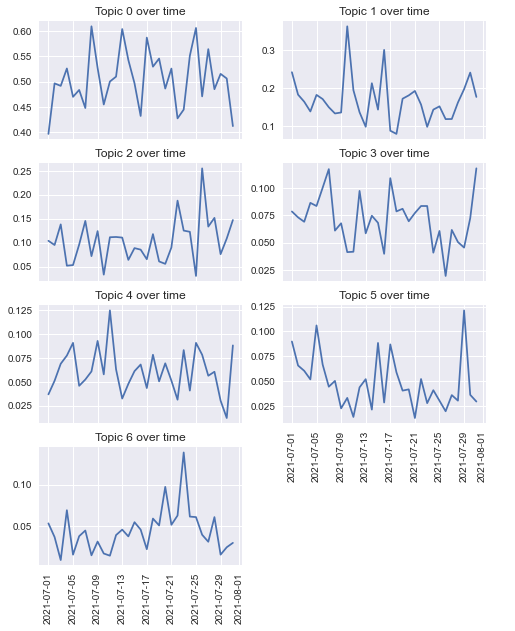

In [42]:
#show the development of tweet frequency of topics over time for the tweets in july
df_july_topic0 = df_july.loc[df_july['topic'] == 0]
df_july_topic1 = df_july.loc[df_july['topic'] == 1]
df_july_topic2 = df_july.loc[df_july['topic'] == 2]
df_july_topic3 = df_july.loc[df_july['topic'] == 3]
df_july_topic4 = df_july.loc[df_july['topic'] == 4]
df_july_topic5 = df_july.loc[df_july['topic'] == 5]
df_july_topic6 = df_july.loc[df_july['topic'] == 6]
df_july_freqs = pd.DataFrame(pd.to_datetime(df_july['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = pd.DataFrame(pd.to_datetime(df_july_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = df_july_topic0.merge(df_july_freqs, on ='index')
df_july_topic0['count'] = df_july_topic0['new_date_x']/df_july_topic0['new_date_y'] 
df_july_topic1 = pd.DataFrame(pd.to_datetime(df_july_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic1 = df_july_topic1.merge(df_july_freqs, on ='index')
df_july_topic1['count'] = df_july_topic1['new_date_x']/df_july_topic1['new_date_y'] 
df_july_topic2 = pd.DataFrame(pd.to_datetime(df_july_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic2 = df_july_topic2.merge(df_july_freqs, on ='index')
df_july_topic2['count'] = df_july_topic2['new_date_x']/df_july_topic2['new_date_y'] 
df_july_topic3 = pd.DataFrame(pd.to_datetime(df_july_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic3 = df_july_topic3.merge(df_july_freqs, on ='index')
df_july_topic3['count'] = df_july_topic3['new_date_x']/df_july_topic3['new_date_y'] 
df_july_topic4 = pd.DataFrame(pd.to_datetime(df_july_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic4 = df_july_topic4.merge(df_july_freqs, on ='index')
df_july_topic4['count'] = df_july_topic4['new_date_x']/df_july_topic4['new_date_y'] 
df_july_topic5 = pd.DataFrame(pd.to_datetime(df_july_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic5 = df_july_topic5.merge(df_july_freqs, on ='index')
df_july_topic5['count'] = df_july_topic5['new_date_x']/df_july_topic5['new_date_y']
df_july_topic6 = pd.DataFrame(pd.to_datetime(df_july_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic6 = df_july_topic6.merge(df_july_freqs, on ='index')
df_july_topic6['count'] = df_july_topic6['new_date_x']/df_july_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_july_topic0['index'], df_july_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_july_topic1['index'], df_july_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_july_topic2['index'], df_july_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_july_topic3['index'], df_july_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_july_topic4['index'], df_july_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_july_topic5['index'], df_july_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_july_topic6['index'], df_july_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

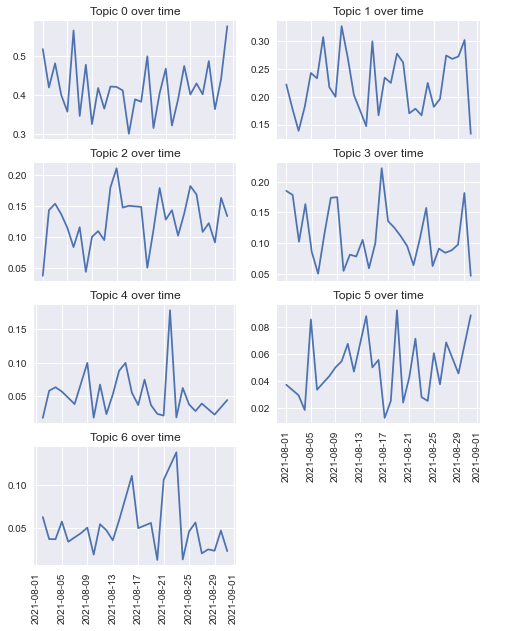

In [43]:
#show the development of tweet frequency of topics over time for the tweets in august
df_august_topic0 = df_august.loc[df_august['topic'] == 0]
df_august_topic1 = df_august.loc[df_august['topic'] == 1]
df_august_topic2 = df_august.loc[df_august['topic'] == 2]
df_august_topic3 = df_august.loc[df_august['topic'] == 3]
df_august_topic4 = df_august.loc[df_august['topic'] == 4]
df_august_topic5 = df_august.loc[df_august['topic'] == 5]
df_august_topic6 = df_august.loc[df_august['topic'] == 6]
df_august_freqs = pd.DataFrame(pd.to_datetime(df_august['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = pd.DataFrame(pd.to_datetime(df_august_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = df_august_topic0.merge(df_august_freqs, on ='index')
df_august_topic0['count'] = df_august_topic0['new_date_x']/df_august_topic0['new_date_y'] 
df_august_topic1 = pd.DataFrame(pd.to_datetime(df_august_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic1 = df_august_topic1.merge(df_august_freqs, on ='index')
df_august_topic1['count'] = df_august_topic1['new_date_x']/df_august_topic1['new_date_y'] 
df_august_topic2 = pd.DataFrame(pd.to_datetime(df_august_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic2 = df_august_topic2.merge(df_august_freqs, on ='index')
df_august_topic2['count'] = df_august_topic2['new_date_x']/df_august_topic2['new_date_y'] 
df_august_topic3 = pd.DataFrame(pd.to_datetime(df_august_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic3 = df_august_topic3.merge(df_august_freqs, on ='index')
df_august_topic3['count'] = df_august_topic3['new_date_x']/df_august_topic3['new_date_y'] 
df_august_topic4 = pd.DataFrame(pd.to_datetime(df_august_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic4 = df_august_topic4.merge(df_august_freqs, on ='index')
df_august_topic4['count'] = df_august_topic4['new_date_x']/df_august_topic4['new_date_y'] 
df_august_topic5 = pd.DataFrame(pd.to_datetime(df_august_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic5 = df_august_topic5.merge(df_august_freqs, on ='index')
df_august_topic5['count'] = df_august_topic5['new_date_x']/df_august_topic5['new_date_y']
df_august_topic6 = pd.DataFrame(pd.to_datetime(df_august_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic6 = df_august_topic6.merge(df_august_freqs, on ='index')
df_august_topic6['count'] = df_august_topic6['new_date_x']/df_august_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_august_topic0['index'], df_august_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_august_topic1['index'], df_august_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_august_topic2['index'], df_august_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_august_topic3['index'], df_august_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_august_topic4['index'], df_august_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_august_topic5['index'], df_august_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_august_topic6['index'], df_august_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

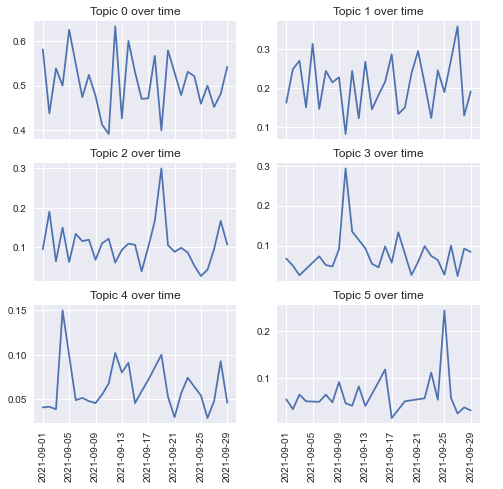

In [44]:
#show the development of tweet frequency of topics over time for the tweets in august
df_september_topic0 = df_september.loc[df_september['topic'] == 0]
df_september_topic1 = df_september.loc[df_september['topic'] == 1]
df_september_topic2 = df_september.loc[df_september['topic'] == 2]
df_september_topic3 = df_september.loc[df_september['topic'] == 3]
df_september_topic4 = df_september.loc[df_september['topic'] == 4]
df_september_topic5 = df_september.loc[df_september['topic'] == 5]
df_september_freqs = pd.DataFrame(pd.to_datetime(df_september['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = pd.DataFrame(pd.to_datetime(df_september_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = df_september_topic0.merge(df_september_freqs, on ='index')
df_september_topic0['count'] = df_september_topic0['new_date_x']/df_september_topic0['new_date_y'] 
df_september_topic1 = pd.DataFrame(pd.to_datetime(df_september_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic1 = df_september_topic1.merge(df_september_freqs, on ='index')
df_september_topic1['count'] = df_september_topic1['new_date_x']/df_september_topic1['new_date_y'] 
df_september_topic2 = pd.DataFrame(pd.to_datetime(df_september_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic2 = df_september_topic2.merge(df_september_freqs, on ='index')
df_september_topic2['count'] = df_september_topic2['new_date_x']/df_september_topic2['new_date_y'] 
df_september_topic3 = pd.DataFrame(pd.to_datetime(df_september_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic3 = df_september_topic3.merge(df_september_freqs, on ='index')
df_september_topic3['count'] = df_september_topic3['new_date_x']/df_september_topic3['new_date_y'] 
df_september_topic4 = pd.DataFrame(pd.to_datetime(df_september_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic4 = df_september_topic4.merge(df_september_freqs, on ='index')
df_september_topic4['count'] = df_september_topic4['new_date_x']/df_september_topic4['new_date_y'] 
df_september_topic5 = pd.DataFrame(pd.to_datetime(df_september_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic5 = df_september_topic5.merge(df_september_freqs, on ='index')
df_september_topic5['count'] = df_september_topic5['new_date_x']/df_september_topic5['new_date_y']
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_september_topic0['index'], df_september_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_september_topic1['index'], df_september_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_september_topic2['index'], df_september_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_september_topic3['index'], df_september_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_september_topic4['index'], df_september_topic4['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_september_topic5['index'], df_september_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

## Proportion of topics within user groups

In [45]:
#identify different user groups for whole data set
df_pos = df.loc[df['user.group'] == "Postdoc"]
df_prom = df.loc[df['user.group'] == "Promovierende"]
df_stu = df.loc[df['user.group'] == "Student"]
df_prof = df.loc[df['user.group'] == "Prof"]
df_med = df.loc[df['user.group'] == "Media"]
df_pol = df.loc[df['user.group'] == "Political rep"]
df_uni = df.loc[df['user.group'] == "Union rep"]
df_ins = df.loc[df['user.group'] == "Institution"]
df_bot = df.loc[df['user.group'] == "Bot"]
df_jun = df.loc[df['user.group'] == "Jun. prof"]
df_tea = df.loc[df['user.group'] == "Teacher"]
df_medic = df.loc[df['user.group'] == "Medical doctor"]
df_ac = df.loc[df['user.group'] == "Academic unspecified"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
df_ac_count = pd.DataFrame(df_ac['topic'].value_counts())
df_ac_count['topic'] = df_ac_count['topic']/len(df_ac)
print('ac')
print(df_ac_count)
print('post')
print(df_pos_count)
print('prom')
print(df_prom_count)
print('student')
print(df_stu_count)
print('prof')
print(df_prof_count)
print('meida')
print(df_med_count)
print('pol')
print(df_pol_count)
print('union')
print(df_uni_count)
print('inst')
print(df_ins_count)

ac
      topic
0  0.529794
1  0.163868
2  0.135157
3  0.099133
4  0.041170
5  0.030878
post
      topic
0  0.511805
2  0.173266
1  0.169996
3  0.083364
4  0.037414
5  0.024155
prom
      topic
0  0.485188
1  0.181745
2  0.160929
3  0.095276
4  0.044035
5  0.032826
student
      topic
0  0.477178
1  0.215768
2  0.116183
3  0.107884
4  0.049793
5  0.033195
prof
      topic
0  0.582996
2  0.169231
1  0.117409
3  0.080972
4  0.028340
5  0.021053
meida
      topic
0  0.593516
1  0.179551
3  0.124688
4  0.044888
2  0.039900
5  0.017456
pol
      topic
0  0.539007
1  0.241135
3  0.085106
4  0.063830
5  0.049645
2  0.021277
union
      topic
1  0.532051
0  0.262821
4  0.102564
2  0.057692
3  0.038462
5  0.006410
inst
      topic
0  0.577358
1  0.230189
2  0.071698
3  0.064151
5  0.041509
4  0.015094


In [46]:
#identify different user groups for german data set
df_pos = df_ger.loc[df_ger['user.group'] == "Postdoc"]
df_prom = df_ger.loc[df_ger['user.group'] == "Promovierende"]
df_stu = df_ger.loc[df_ger['user.group'] == "Student"]
df_prof = df_ger.loc[df_ger['user.group'] == "Prof"]
df_med = df_ger.loc[df_ger['user.group'] == "Media"]
df_pol = df_ger.loc[df_ger['user.group'] == "Political rep"]
df_uni = df_ger.loc[df_ger['user.group'] == "Union rep"]
df_ins = df_ger.loc[df_ger['user.group'] == "Institution"]
df_bot = df_ger.loc[df_ger['user.group'] == "Bot"]
df_jun = df_ger.loc[df_ger['user.group'] == "Jun. prof"]
df_tea = df_ger.loc[df_ger['user.group'] == "Teacher"]
df_medic = df_ger.loc[df_ger['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
5  0.172162
3  0.136756
4  0.131888
0  0.127462
2  0.117283
1  0.109980
7  0.106439
6  0.098031
      topic
5  0.165377
3  0.143133
0  0.139265
1  0.119923
2  0.116054
7  0.112186
4  0.111219
6  0.092843
      topic
1  0.183962
3  0.165094
5  0.150943
6  0.113208
2  0.103774
0  0.099057
4  0.094340
7  0.089623
      topic
5  0.162376
4  0.157426
3  0.141584
1  0.123762
0  0.119802
6  0.110891
7  0.094059
2  0.090099
      topic
5  0.177378
4  0.133676
2  0.131105
7  0.118252
3  0.113111
1  0.113111
0  0.113111
6  0.100257
      topic
5  0.290780
6  0.156028
2  0.113475
3  0.113475
1  0.106383
0  0.092199
7  0.070922
4  0.056738
      topic
7  0.441472
5  0.173913
6  0.090301
0  0.083612
4  0.063545
1  0.053512
3  0.053512
2  0.040134
      topic
7  0.146341
0  0.138211
3  0.130081
1  0.126016
5  0.126016
6  0.126016
4  0.113821
2  0.093496
      topic
7  0.178571
2  0.142857
5  0.125000
6  0.125000
4  0.125000
1  0.125000
3  0.107143
0  0.071429
      topic
3  0.172840
1  0

In [47]:
#identify different user groups for english data set
df_pos = df_en.loc[df_en['user.group'] == "Postdoc"]
df_prom = df_en.loc[df_en['user.group'] == "Promovierende"]
df_stu = df_en.loc[df_en['user.group'] == "Student"]
df_prof = df_en.loc[df_en['user.group'] == "Prof"]
df_med = df_en.loc[df_en['user.group'] == "Media"]
df_pol = df_en.loc[df_en['user.group'] == "Political rep"]
df_uni = df_en.loc[df_en['user.group'] == "Union rep"]
df_ins = df_en.loc[df_en['user.group'] == "Institution"]
df_bot = df_en.loc[df_en['user.group'] == "Bot"]
df_jun = df_en.loc[df_en['user.group'] == "Jun. prof"]
df_tea = df_en.loc[df_en['user.group'] == "Teacher"]
df_medic = df_en.loc[df_en['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
6  0.213779
2  0.182371
0  0.182371
3  0.138804
4  0.106383
5  0.096251
1  0.080041
      topic
2  0.223256
0  0.190698
3  0.158140
6  0.134884
5  0.111628
1  0.102326
4  0.079070
      topic
2  0.206897
0  0.172414
3  0.172414
4  0.172414
1  0.137931
6  0.103448
5  0.034483
      topic
2  0.208889
3  0.151111
5  0.142222
0  0.142222
4  0.128889
6  0.124444
1  0.102222
      topic
0  0.583333
3  0.166667
2  0.166667
6  0.083333
Empty DataFrame
Columns: [topic]
Index: []
      topic
5  0.461538
2  0.307692
6  0.230769
      topic
6  0.263158
1  0.263158
2  0.210526
5  0.157895
0  0.052632
4  0.052632
   topic
3    0.5
0    0.5
      topic
3  0.444444
5  0.222222
6  0.222222
4  0.111111
      topic
1  0.666667
2  0.333333
Empty DataFrame
Columns: [topic]
Index: []


In [48]:
#identify different user groups for June
df_pos = df_june.loc[df_june['user.group'] == "Postdoc"]
df_prom = df_june.loc[df_june['user.group'] == "Promovierende"]
df_stu = df_june.loc[df_june['user.group'] == "Student"]
df_prof = df_june.loc[df_june['user.group'] == "Prof"]
df_med = df_june.loc[df_june['user.group'] == "Media"]
df_pol = df_june.loc[df_june['user.group'] == "Political rep"]
df_uni = df_june.loc[df_june['user.group'] == "Union rep"]
df_ins = df_june.loc[df_june['user.group'] == "Institution"]
df_bot = df_june.loc[df_june['user.group'] == "Bot"]
df_jun = df_june.loc[df_june['user.group'] == "Jun. prof"]
df_tea = df_june.loc[df_june['user.group'] == "Teacher"]
df_medic = df_june.loc[df_june['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.366192
1  0.186653
3  0.154810
2  0.106369
5  0.068428
6  0.064702
4  0.052846
      topic
0  0.364146
1  0.204482
3  0.158263
2  0.107843
5  0.071429
6  0.053221
4  0.040616
      topic
0  0.358108
3  0.189189
1  0.189189
2  0.074324
4  0.067568
5  0.060811
6  0.060811
      topic
0  0.379487
1  0.202564
3  0.148718
2  0.114103
5  0.060256
4  0.056410
6  0.038462
      topic
0  0.307692
1  0.210526
3  0.194332
4  0.093117
2  0.072874
5  0.064777
6  0.056680
      topic
0  0.420561
3  0.233645
1  0.112150
5  0.074766
4  0.074766
6  0.046729
2  0.037383
      topic
0  0.440367
4  0.183486
1  0.174312
3  0.100917
2  0.045872
6  0.036697
5  0.018349
      topic
0  0.275862
1  0.224138
3  0.172414
2  0.129310
4  0.094828
6  0.051724
5  0.051724
      topic
5  0.384615
0  0.230769
1  0.153846
3  0.153846
2  0.076923
      topic
1  0.280702
0  0.210526
3  0.175439
2  0.122807
5  0.087719
6  0.070175
4  0.052632
      topic
3  0.333333
1  0.291667
0  0.166667
2  0.125000
6  0

In [49]:
#identify different user groups for July
df_pos = df_july.loc[df_july['user.group'] == "Postdoc"]
df_prom = df_july.loc[df_july['user.group'] == "Promovierende"]
df_stu = df_july.loc[df_july['user.group'] == "Student"]
df_prof = df_july.loc[df_july['user.group'] == "Prof"]
df_med = df_july.loc[df_july['user.group'] == "Media"]
df_pol = df_july.loc[df_july['user.group'] == "Political rep"]
df_uni = df_july.loc[df_july['user.group'] == "Union rep"]
df_ins = df_july.loc[df_july['user.group'] == "Institution"]
df_bot = df_july.loc[df_july['user.group'] == "Bot"]
df_jun = df_july.loc[df_july['user.group'] == "Jun. prof"]
df_tea = df_july.loc[df_july['user.group'] == "Teacher"]
df_medic = df_july.loc[df_july['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.457447
1  0.212766
2  0.102128
3  0.066667
5  0.065248
4  0.059574
6  0.036170
      topic
0  0.555147
1  0.150735
2  0.139706
5  0.040441
3  0.040441
6  0.036765
4  0.036765
      topic
0  0.508475
3  0.135593
1  0.118644
4  0.101695
2  0.067797
5  0.050847
6  0.016949
      topic
0  0.483974
1  0.192308
2  0.092949
4  0.089744
5  0.054487
6  0.044872
3  0.041667
      topic
0  0.545455
3  0.142857
2  0.116883
1  0.090909
6  0.051948
4  0.025974
5  0.025974
      topic
0  0.642857
2  0.142857
1  0.071429
6  0.071429
4  0.071429
      topic
0  0.625000
5  0.097222
3  0.083333
1  0.083333
2  0.055556
6  0.027778
4  0.027778
      topic
0  0.480000
1  0.200000
5  0.106667
2  0.106667
4  0.053333
3  0.053333
   topic
1    1.0
    topic
0  0.4375
2  0.1875
4  0.1875
1  0.1250
3  0.0625
   topic
1   0.50
0   0.25
2   0.25
Empty DataFrame
Columns: [topic]
Index: []


In [50]:
#identify different user groups for August
df_pos = df_august.loc[df_august['user.group'] == "Postdoc"]
df_prom = df_august.loc[df_august['user.group'] == "Promovierende"]
df_stu = df_august.loc[df_august['user.group'] == "Student"]
df_prof = df_august.loc[df_august['user.group'] == "Prof"]
df_med = df_august.loc[df_august['user.group'] == "Media"]
df_pol = df_august.loc[df_august['user.group'] == "Political rep"]
df_uni = df_august.loc[df_august['user.group'] == "Union rep"]
df_ins = df_august.loc[df_august['user.group'] == "Institution"]
df_bot = df_august.loc[df_august['user.group'] == "Bot"]
df_jun = df_august.loc[df_august['user.group'] == "Jun. prof"]
df_tea = df_august.loc[df_august['user.group'] == "Teacher"]
df_medic = df_august.loc[df_august['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.445880
1  0.200323
3  0.121163
2  0.113086
5  0.042003
4  0.038772
6  0.038772
      topic
0  0.496403
1  0.172662
3  0.122302
2  0.115108
4  0.043165
6  0.028777
5  0.021583
      topic
0  0.571429
1  0.285714
4  0.071429
3  0.071429
      topic
0  0.521739
1  0.184783
2  0.086957
3  0.076087
6  0.065217
5  0.054348
4  0.010870
      topic
1  0.415094
2  0.207547
0  0.188679
5  0.113208
3  0.037736
6  0.018868
4  0.018868
      topic
1  0.454545
0  0.363636
3  0.090909
2  0.090909
      topic
1  0.410714
0  0.250000
5  0.107143
2  0.107143
3  0.071429
6  0.035714
4  0.017857
      topic
0  0.307692
1  0.307692
3  0.115385
2  0.115385
6  0.076923
4  0.038462
5  0.038462
      topic
1  0.433333
0  0.266667
2  0.166667
4  0.066667
3  0.066667
      topic
1  0.285714
3  0.285714
0  0.214286
2  0.142857
6  0.071429
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []


In [51]:
#identify different user groups for September
df_pos = df_september.loc[df_september['user.group'] == "Postdoc"]
df_prom = df_september.loc[df_september['user.group'] == "Promovierende"]
df_stu = df_september.loc[df_september['user.group'] == "Student"]
df_prof = df_september.loc[df_september['user.group'] == "Prof"]
df_med = df_september.loc[df_september['user.group'] == "Media"]
df_pol = df_september.loc[df_september['user.group'] == "Political rep"]
df_uni = df_september.loc[df_september['user.group'] == "Union rep"]
df_ins = df_september.loc[df_september['user.group'] == "Institution"]
df_bot = df_september.loc[df_september['user.group'] == "Bot"]
df_jun = df_september.loc[df_september['user.group'] == "Jun. prof"]
df_tea = df_september.loc[df_september['user.group'] == "Teacher"]
df_medic = df_september.loc[df_september['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.495238
1  0.205714
3  0.104762
2  0.099048
4  0.062857
5  0.032381
      topic
0  0.475806
1  0.185484
2  0.145161
5  0.080645
3  0.064516
4  0.048387
   topic
0   0.65
1   0.25
2   0.05
4   0.05
      topic
0  0.470588
1  0.196078
2  0.137255
3  0.098039
4  0.058824
5  0.039216
      topic
0  0.541667
2  0.250000
1  0.125000
4  0.041667
3  0.041667
      topic
0  0.666667
3  0.111111
5  0.111111
1  0.111111
      topic
0  0.466667
1  0.333333
3  0.066667
2  0.066667
5  0.053333
4  0.013333
      topic
0  0.541667
1  0.187500
2  0.125000
5  0.083333
4  0.041667
3  0.020833
      topic
2  0.333333
0  0.333333
1  0.333333
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []


In [52]:
print("Topics for the whole model")
print("------ Topic 0: Temporary contracts after promotion ------")
print("jahren jahre stellen immer @anjakarliczek warum promotion system einfach stelle\n")

print("------ Topic 1: Discussion in the German Bundestag ------")
print("#hannaimbundestag @anjakarliczek heute arbeitsbedingungen immer thema hochschulen letzten debatte unis\n")

print("------ Topic 2: WissZeitVG and research in Germany------")
print("forschung lehre system deutschland gerade @gew_bund wisszeitvg #wissenschaft hochschulen problem\n")

print("------ Topic 3: Labour Union GEW ------")
print("system #hannabeidergew stelle @gew_bund forschung tweets @mahaelhissy #95vswisszeitvg #acertaindegreeofflexibility macht\n")

print("------ Topic 4:  General topic about research in Germany(similar to topic 2)------")
print("deutschland forschung #ichbinreyhan jahre lehre bitte unis arbeit @gew_bund müssen\n")

print("------ Topic 5: English topic about temporary contracts and working conditions ------")
print("system research work years contracts working many conditions researchers time")

Topics for the whole model
------ Topic 0: Temporary contracts after promotion ------
jahren jahre stellen immer @anjakarliczek warum promotion system einfach stelle

------ Topic 1: Discussion in the German Bundestag ------
#hannaimbundestag @anjakarliczek heute arbeitsbedingungen immer thema hochschulen letzten debatte unis

------ Topic 2: WissZeitVG and research in Germany------
forschung lehre system deutschland gerade @gew_bund wisszeitvg #wissenschaft hochschulen problem

------ Topic 3: Labour Union GEW ------
system #hannabeidergew stelle @gew_bund forschung tweets @mahaelhissy #95vswisszeitvg #acertaindegreeofflexibility macht

------ Topic 4:  General topic about research in Germany(similar to topic 2)------
deutschland forschung #ichbinreyhan jahre lehre bitte unis arbeit @gew_bund müssen

------ Topic 5: English topic about temporary contracts and working conditions ------
system research work years contracts working many conditions researchers time
